<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.09/6_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2023-02-09/4차시

/content/drive/MyDrive/2023-02-09/4차시


# Style transfer(필요 라이브러리 임포트) - #1

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Style transfer(데이터 전처리 함수) - #2

In [ ]:
# 원하는 출력 이미지의 크기
imsize = 512 if torch.cuda.is_available() else 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # 가져온 이미지 크기 조정
    transforms.ToTensor()])  # 텐서로 변환


def image_loader(image_name):
    image = Image.open(image_name)
    # 네트워크의 입력 차원에 맞추기 위해 필요한 가짜 배치 차원
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("ST_images/picasso.jpg")
content_img = image_loader("ST_images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

# Style transfer(영상 데이터 출력) - #3

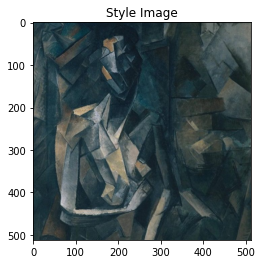

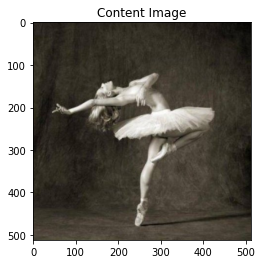

In [ ]:
unloader = transforms.ToPILImage()  # PIL 이미지로 다시 변환

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서를 복제하여 변경하지 않음
    image = image.squeeze(0)      # 가짜 배치 차원 제거
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # plots가 업데이트 되도록 잠시 멈춤


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Style transfer(손실클래스 생성) - #4

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # 기울기를 동적으로 계산하는데 사용되는 tree로부터 타깃 Content를 분리
        # 그렇지 않으면 criterion의 forward 메소드에서 오류가 발생
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=배치 크기(=1)
    # b=특징 맵의 수
    # (c,d)=특징 맵의 차원 (N=c*d)

    features = input.view(a * b, c * d)  # F_XL을 \hat F_XL로 크기 조정
    G = torch.mm(features, features.t())  # gram product를 계산

    # 각 특징 맵이 갖는 값의 수로 나누어
    # gram 행렬의 값을 '정규화'
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Style transfer(데이터 정규화) - #5


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# 입력 이미지를 정규화하는 모듈을 생성하여 nn.Sequential에 넣음
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view 는 mean과 std을 확인해 [B x C x H x W] 형태의
        # 이미지 텐서를 직접적으로 작업할 수 있도록 [C x 1 x 1] 형태로 듬
        # B는 배치 크기입니다. C는 채널의 수, H는 높이고 W는 너비
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # img 정규화
        return (img - self.mean) / self.std

# Style transfer(모델과 손실값 가져오기) - #6

In [ ]:
# Style / Content 손실 계산을 원하는 계층
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # 모듈 정규화
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Content / Style 손실이 반복적으로 접근할 수 있도록 하기 위해
    content_losses = []
    style_losses = []

    # cnn이 nn.Sequential이라고 가정하고,
    # 순차적으로 활성화되어야 하는 모듈에 새로운 nn.Sequential을 만듬.
    model = nn.Sequential(normalization)

    i = 0  # conv를 볼 때마다 증가
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # in-place 버전은 아래에 삽입한 Content 손실과 Style 손실와 잘 어울리지 않아서
            # 여기서는 out-of-place로 대체함.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        print(name)

        model.add_module(name, layer)

        if name in content_layers:
            # Content 손실 추가
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # Style 손실 추가
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Style transfer(입력영상 출력) - #7

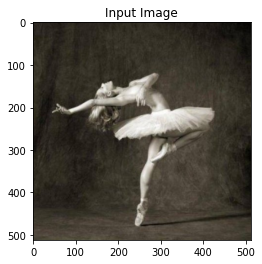

In [ ]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device)

# 그림에 원본 입력 이미지를 추가
plt.figure()
imshow(input_img, title='Input Image')

# Style transfer(최적화 함수 및 스타일 트랜스퍼 학습) - #8

In [ ]:
def get_input_optimizer(input_img):
    # 입력이 기울기가 필요한 매개 변수임을 표시하는 줄
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # 모델의 매개변수를 제외한 입력을 최적화해야 하므로
    # 이에 맞춰서 requires_grad 값을 갱신합니다.
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # 업데이트 된 입력 이미지의 값을 수정
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # 마지막 수정...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
conv_1


<ipython-input-19-c1bb6ce14b79>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-19-c1bb6ce14b79>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


relu_1
conv_2
relu_2
pool_2
conv_3
relu_3
conv_4
relu_4
pool_4
conv_5
relu_5
conv_6
relu_6
conv_7
relu_7
conv_8
relu_8
pool_8
conv_9
relu_9
conv_10
relu_10
conv_11
relu_11
conv_12
relu_12
pool_12
conv_13
relu_13
conv_14
relu_14
conv_15
relu_15
conv_16
relu_16
pool_16
Optimizing..
run [50]:
Style Loss : 4.136172 Content Loss: 4.194388

run [100]:
Style Loss : 1.151775 Content Loss: 3.044275

run [150]:
Style Loss : 0.714675 Content Loss: 2.658046

run [200]:
Style Loss : 0.476158 Content Loss: 2.498995

run [250]:
Style Loss : 0.346834 Content Loss: 2.411512

run [300]:
Style Loss : 0.267149 Content Loss: 2.359577



# Style transfer(예측 결과 출력) - #9


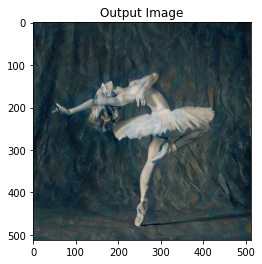

In [ ]:
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()